# Credit Card Classification

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, recall_score, auc, accuracy_score, f1_score, precision_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline as imb_pipeline
from imblearn.over_sampling import SMOTE, SMOTEN, RandomOverSampler, BorderlineSMOTE

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier


# Functions

In [2]:
def check_nulls_dupes(df):
  print(f"The Amount of Null Values: {df.isna().sum()}")
  print(f"The Amount of Duplicated Values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 8))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 8))
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.show()

def create_sklearn_pipeline(model):
  
  return Pipeline(
    steps=[
      ("Scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer()),
      ("model", model)
    ]
  )

def sampling_pipeline(model, sampling_model, kbest=None):
  
  steps = [
    ("Scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("sampling", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return imb_pipeline(
    steps=steps
  )

def pca_analysis(X):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []

  for n_component in features:
    pca = PCA(n_components=n_component)
    pipeline = create_sklearn_pipeline(pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    
    metric_tracker.append(
      {
        "Component":n_component,
        "CumSum": cumsum
      }
    )
    
    df = pd.DataFrame(metric_tracker)
    
    plt.figure(figsize=(20, 12))
    plt.title("PCA Analysis")
    sns.barplot(data=df, x="Component", y="CumSum")
    plt.xlabel("Components")
    plt.ylabel("CumSum")
    plt.show()
    
    return df

def plot_dataset(df, visual_type):
  
  plt.figure(figsize=(16,16))
  cols = len(df.columns)
  rows = (cols +3)//4
  
  for idx, col in enumerate(df.columns):
    plt.subplot(rows, 4, idx+1)
    plt.title(col)
    sns.histplot(data=df[col], kde=True) if visual_type == "hist" else sns.boxplot(df[col])
    plt.xlabel(col)
  
  plt.tight_layout()
  plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  for col in interested_columns:
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=5)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(sampling_model, model_names, models, X, y, scoring_metric, kbest=None):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = sampling_pipeline(model, sampling_model, kbest) if kbest else sampling_pipeline(model, sampling_model) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df

def test_kbest_columns(sampling_model, X, y, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = sampling_pipeline(model, sampling_model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  return pd.DataFrame(metric_tracker)

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/creditcard.csv", nrows=25000)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,33469,-0.311372,0.759277,1.650994,1.091764,0.747545,0.924909,0.675067,-0.052870,-0.170135,...,-0.040939,0.357128,-0.406407,-0.871783,0.265729,-0.089932,-0.000652,-0.116323,20.00,0
24996,33469,-0.745983,0.518650,1.533865,1.335173,0.376647,0.019838,0.221768,0.328102,-0.390842,...,0.054737,0.314848,-0.034032,0.218806,-0.161277,-0.250516,0.402972,0.202283,18.04,0
24997,33470,-0.618962,1.302587,1.182654,-0.046862,0.267769,-0.527204,0.658724,0.029762,-0.331111,...,-0.259006,-0.529602,0.006277,0.042659,-0.155856,0.103680,0.378294,0.154449,1.79,0
24998,33471,1.377620,-0.279881,0.119446,-0.594892,-0.764533,-1.241617,-0.010524,-0.388173,-1.259304,...,-0.784787,-1.841549,0.264707,0.388256,0.013974,0.618726,-0.072529,0.013620,25.48,0


# Check For Nulls

In [4]:
check_nulls_dupes(df)

The Amount of Null Values: Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
The Amount of Duplicated Values: 95


In [5]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

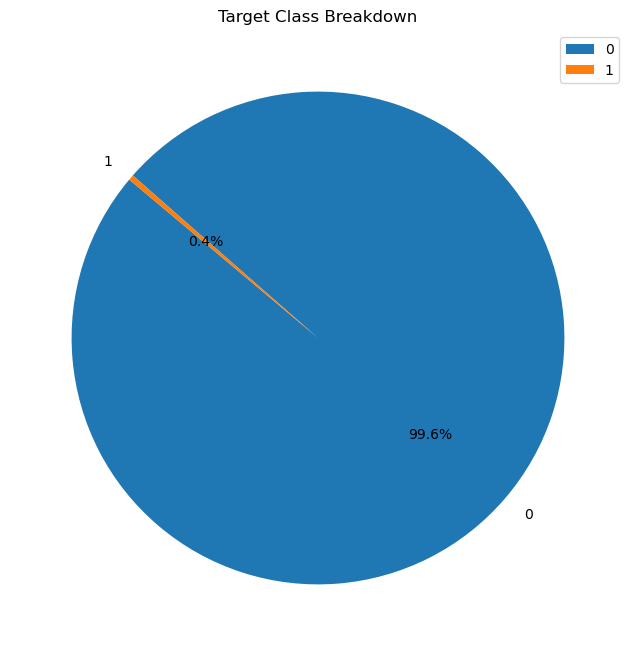

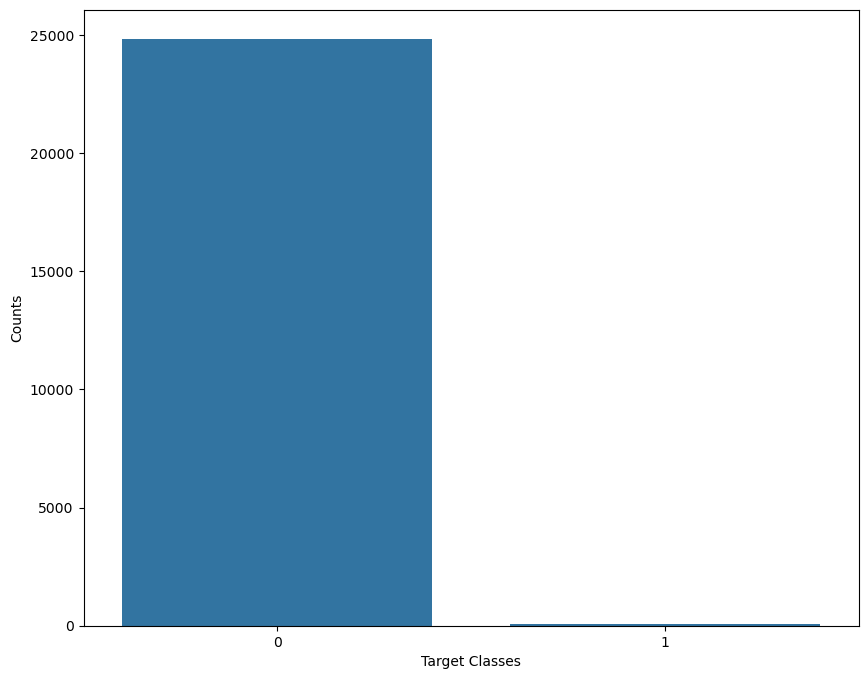

In [6]:
check_class_imbalance(df["Class"])

# Major Class Balance

# Heat Map

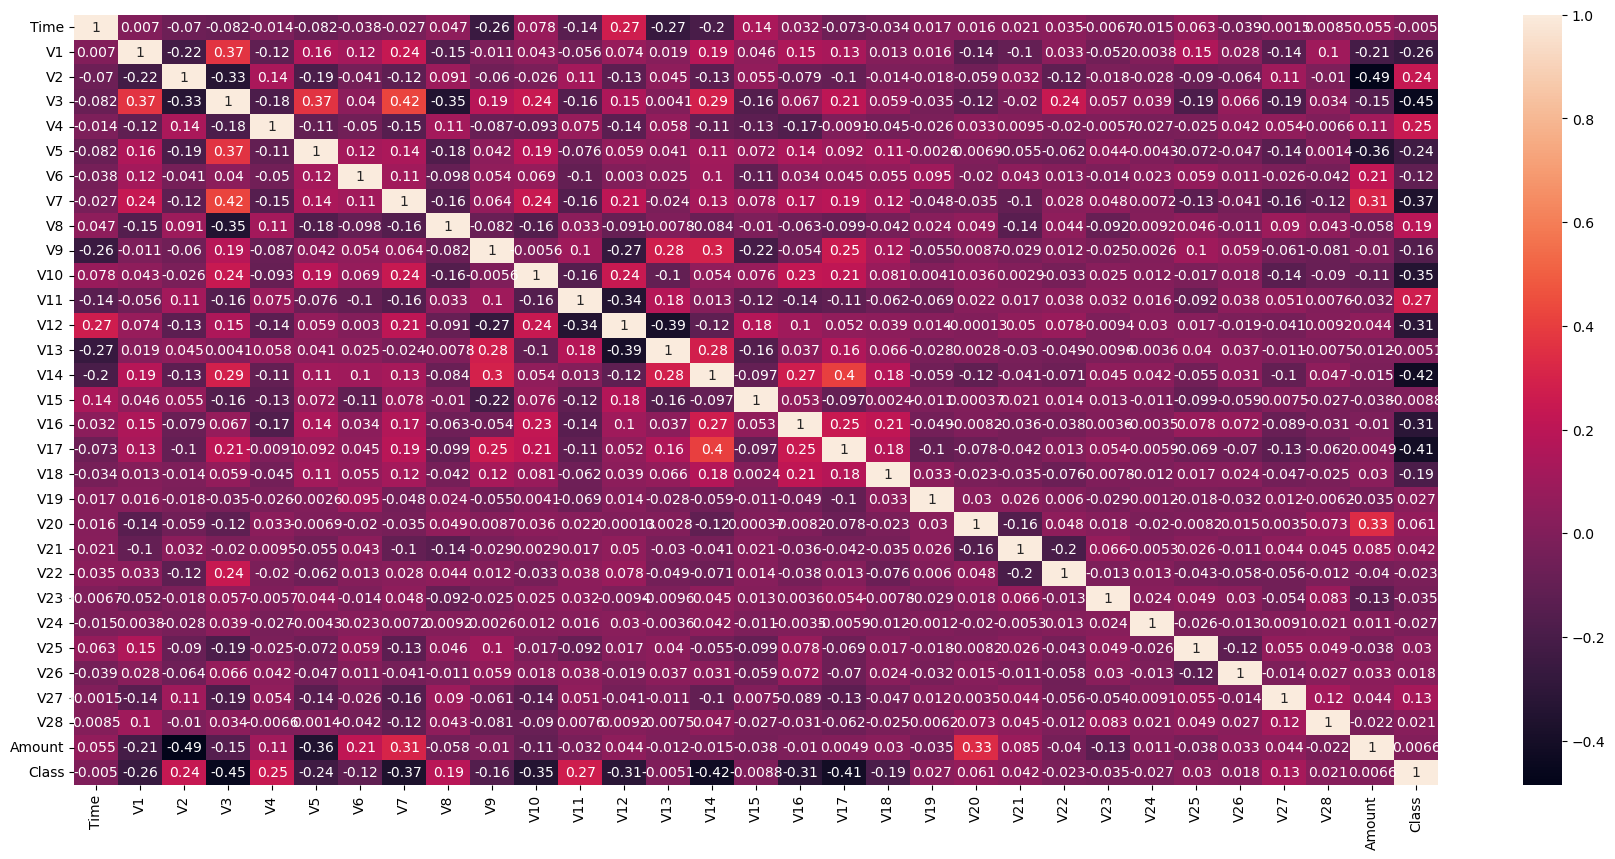

In [7]:
plt.figure(figsize=(22, 10))
relations = df.corr()
sns.heatmap(data=relations, annot=True)
plt.show()

# Separate Feature Variables

In [8]:
X = df.drop("Class", axis=1)
y = df["Class"]

# Metrics

In [9]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

# Check Baseline Model

In [13]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
sampling_models = [SMOTE(), SMOTEN(), RandomOverSampler(), BorderlineSMOTE()]

for sample_model in sampling_models:
  print(f"Sample Model: {sample_model}")
  print(test_selected_models(sample_model, model_name, models, X, y, f1_metric))

Sample Model: SMOTE()
   Model   Mean  Var    STD  Test-Acc  recall-Score  precision-Score  F1-Score
0  DUMMY  0.664  0.0  0.009     0.501         0.523              0.5     0.337
Sample Model: SMOTEN()
